In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## UNRATE Data for graded question

In [2]:
df5 = pd.read_csv(r"./UNRATE.csv")
df5.columns = ['date', 'unemployment_rate']
df5['date'] = pd.to_datetime(df5['date'], format='%d-%m-%Y')
df5 = df5.set_index('date')
df5.head()

,unemployment_rate
date,
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5
1948-06-01,3.6


In [3]:
df5.shape

(866, 1)

### Plot data

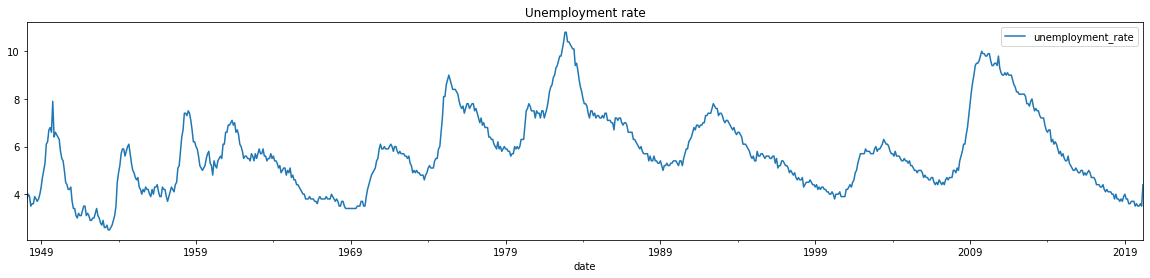

In [4]:
df5.plot(figsize=(20, 4))
plt.legend(loc='best')
plt.title('Unemployment rate')
plt.show(block=False)

#### Box Cox transformation

Text(0.5, 1.0, 'After boxcox transformation')

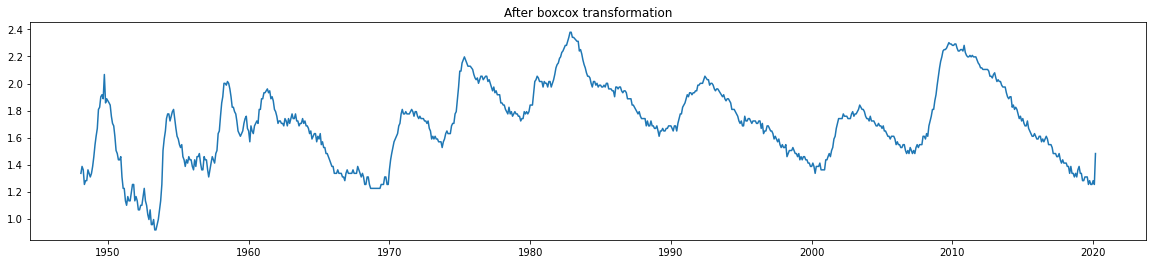

In [5]:
from scipy.stats import boxcox
df5_boxcox = pd.Series(boxcox(df5['unemployment_rate'], lmbda = 0), index = df5.index)

plt.figure(figsize=(20,4))
plt.plot(df5_boxcox, label = "After boxcox transformation")
plt.title('After boxcox transformation')

### Differencing

Text(0.5, 1.0, 'After boxcox & differencing transformation')

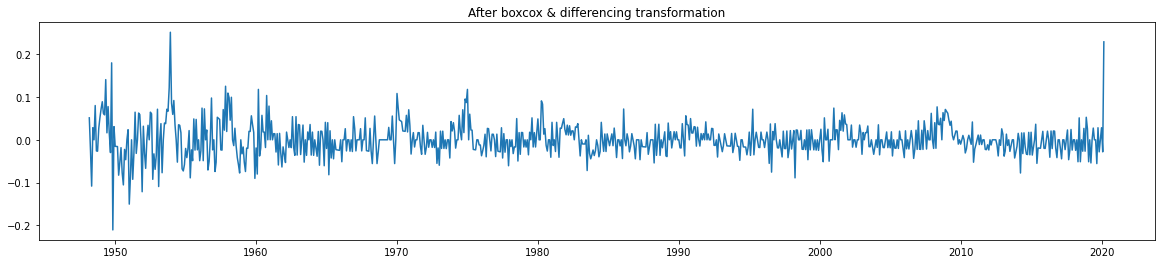

In [6]:
df5_boxcox_diff = pd.Series(df5_boxcox - df5_boxcox.shift(), index= df5.index)
df5_boxcox_diff.dropna(inplace = True)

plt.figure(figsize=(20,4))
plt.plot(df5_boxcox_diff, label = "After boxcox & differencing transformation")
plt.title('After boxcox & differencing transformation')

### ADF Test

In [7]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df5_boxcox_diff)

print('ADF statistic:%f' %adf_test[0])
print('Critical value @ 0.05:%f' %adf_test[4]['5%'])
print('Pvalue:%f' %adf_test[1])

ADF statistic:-25.774850
Critical value @ 0.05:-2.864891
Pvalue:0.000000


C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


#### Since, ADF statistic value is less than critical value, fail to reject the null (Null- Series is not stationary) hypothesis.
#### Series is stationary

### ACF Plot

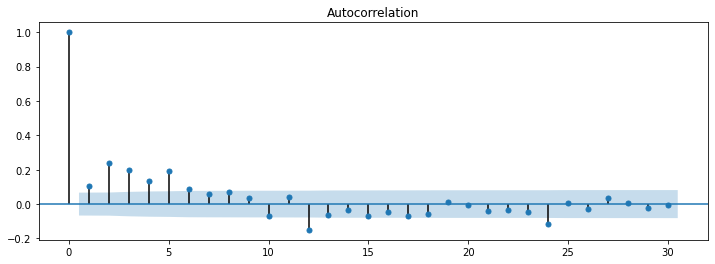

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(12,4))
plot_acf(df5_boxcox_diff, ax = plt.gca(), lags =30)
plt.show()

### PACF Plot

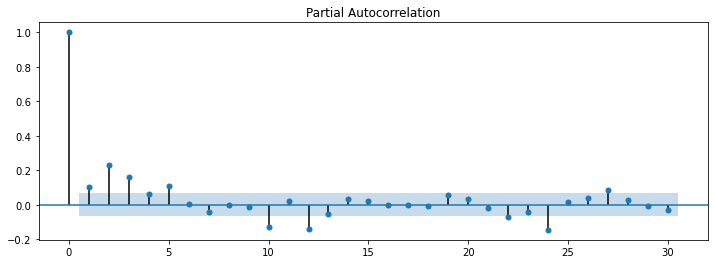

In [9]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(12,4))
plot_pacf(df5_boxcox_diff, ax = plt.gca(), lags =30)
plt.show()

### Split data into train test

In [10]:
trainlen = 612
train_df5_boxcox = df5_boxcox[0:trainlen]
test_df5_boxcox = df5_boxcox[trainlen:]

train_df5_boxcox_diff = df5_boxcox_diff[:trainlen-1]
test_df5_boxcox_diff = df5_boxcox_diff[trainlen-1:]

### Auto Regression method (AR)

In [11]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_df5_boxcox_diff, order = (12,0,0))
model_fit = model.fit()
print(model_fit.params)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


const       0.000074
ar.L1.y     0.049595
ar.L2.y     0.164803
ar.L3.y     0.138577
ar.L4.y     0.086970
ar.L5.y     0.103376
ar.L6.y    -0.004551
ar.L7.y    -0.023162
ar.L8.y     0.041230
ar.L9.y     0.010450
ar.L10.y   -0.129813
ar.L11.y    0.035154
ar.L12.y   -0.159249
dtype: float64


### Recover original time series to forecast

In [12]:
end_index = len(df5_boxcox_diff)
end_index 

865

In [13]:
df5_boxcox_diff.iloc[-1:]

date
2020-03-01    0.228842
dtype: float64

In [14]:
df5_boxcox_diff.index.min()

Timestamp('1948-03-01 00:00:00')

In [15]:
y_hat_ar = df5_boxcox_diff.copy()

y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(df5_boxcox_diff.index.min(), df5_boxcox_diff.index.max())

y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()

y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(df5_boxcox[0])

y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

In [ ]:
len(y_hat_ar['ar_forecast'])